In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables



C:\Users\twpot\AppData\Local\Temp\ipykernel_21300\2827681608.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found

Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table

station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB

Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

most_recent_date = session\
    .query(func.max(measurement.date))\
    .first()

most_recent_date

('2017-08-23',)

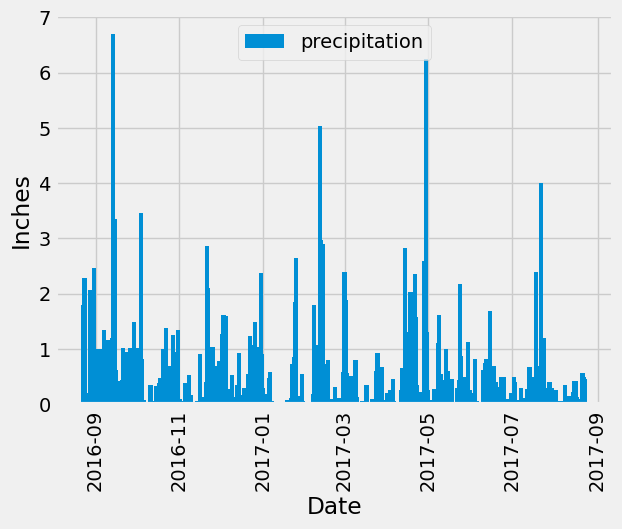

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

twelve_months_back = (pd.to_datetime(most_recent_date[0]) - dt.timedelta(days=365)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores

data = session\
    .query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= twelve_months_back)\
    .order_by(measurement.date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(data, columns=["date","precipitation"])

# Sort the dataframe by date

df = df.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data

df["date"] = pd.to_datetime(df["date"])
plt.bar(x=df["date"], height=df["precipitation"], width=3)
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Inches")
plt.legend(["precipitation"], loc='upper center', bbox_to_anchor=(0.5, 1))
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data

pd.DataFrame(df["precipitation"].describe())

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset

total = session.query(func.count(station.id)).all()
total

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_counts = session\
    .query(measurement.station, func.count(measurement.id))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.id).desc())\
    .all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = station_counts[0][0]

station_data = session\
    .query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
    .filter(measurement.station == most_active_station_id)\
    .all()

station_data

[(54.0, 85.0, 71.66378066378067)]

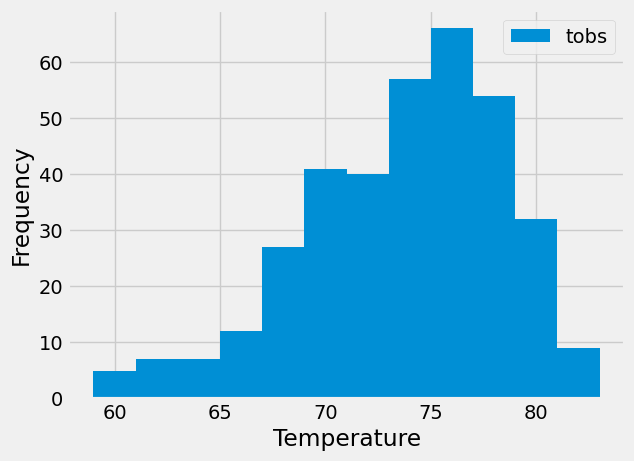

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_recent_date2 = session\
    .query(func.max(measurement.date))\
    .filter(measurement.station == most_active_station_id)\
    .first()

twelve_months_back2 = (pd.to_datetime(most_recent_date2[0]) - dt.timedelta(days=365)).strftime("%Y-%m-%d")

data2 = session\
    .query(measurement.date, measurement.tobs)\
    .filter(measurement.station == most_active_station_id, measurement.date >= twelve_months_back2)\
    .order_by(measurement.date)\
    .all()

df2 = pd.DataFrame(data2, columns=["date","tobs"])
df2 = df2.sort_values(by="date")

df2["date"] = pd.to_datetime(df2["date"])
plt.hist(x=df2["tobs"], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()

# Close Session

In [16]:
# Close Session
session.close()